# Project description

We have collected historical data on airpot taxi orders from a company. To attract more drivers during peak hours for Sweet Lift Taxi company, a prediction is needed for the amount of taxi orders in the next hour. Here I will build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project projections

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
print('platform')

    

platform


In [3]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
print(df.info())
print()
print('shape:', df.shape)
print()
print('duplicates:', df.duplicated().sum())
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None

shape: (26496, 2)

duplicates: 0


datetime      0
num_orders    0
dtype: int64

In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

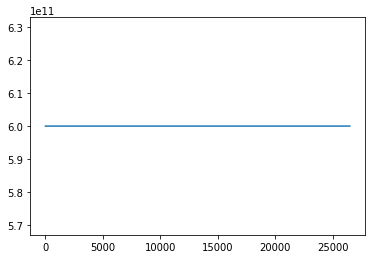

In [6]:
# length of the dataset
display(df['datetime'].min(), df['datetime'].max())
# check for gaps
(df['datetime'] - df['datetime'].shift()).plot()
plt.show()

## Analysis

In [7]:
# Make new feature columns for month, day,  dayofweek, hour

# predictions are required for the next hour
df_hour = df.copy(deep=True)
df_hour.set_index('datetime', inplace=True)
df_hour = df_hour.resample('1H').sum()

In [10]:
df_hour.dtypes


num_orders    int64
dtype: object

In [ ]:
def create_features(df, dt_field, target, max_lag=1, rolling_window=1):

    #Making time series features

    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(str(lag))] = df[target].shift(lag)
    
    df['rolling_mean'] = df[target].shift().rolling(rolling_window).mean()
    df['rolling_median'] = df[target].shift().rolling(rolling_window).median()
    df['rolling_std'] = df[target].shift().rolling(rolling_window).std()

In [ ]:
create_features(df_hour, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

In [ ]:
df_hour.head()

In [ ]:
df_hour.info()

In [ ]:
def put_orders(data, field, r=1, c=1, figsize=(8, 6), is_mean_window=False,
                window=1, titles=[], sup_title=None):
  
    # Plot mean orders based on different time intervals
 
    fig, axes = plt.subplots(r, c, figsize=figsize)
    if not is_mean_window:
        for idx, (data, title, ax) in enumerate(zip(data, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax)
            axes[idx].set_title(title)
    else:
        for idx, (data, title, ax) in enumerate(zip(data, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax, label='hourly trend')
            sns.lineplot(df.index, df.shift().rolling(window).mean(), ax=ax, label='mean')
            sns.lineplot(df.index, df.shift().rolling(window).std(), ax=ax, label='std')
            axes[idx].set_title(title)
    axes.flat[-1].set_visible(False) 
    plt.suptitle(sup_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:

# Resample df on an hourly, daily, and monthly basis
hourly_orders = df.set_index('datetime')['num_orders'].resample('1H').mean()
daily_orders = df.set_index('datetime')['num_orders'].resample('1D').mean()
monthly_orders = df.set_index('datetime')['num_orders'].resample('1M').mean()

# Combine the resampled data into a new DataFrame
df_resample = pd.concat([hourly_orders, daily_orders, monthly_orders], axis=1)
df_resample.columns = ['Hourly', 'Daily', 'Monthly']  # Rename columns

# Reset the index to have 'datetime' as a regular column
df_resample = df_resample.reset_index()

# Define titles
titles = ['Hourly mean orders', 'Daily mean orders', 'Monthly mean orders']
sup_title = 'Trend of orders by various intervals - 2018-03-01 to 2018-08-31'

# Plot the data
ax = df_resample.plot(x='datetime', figsize=(10, 6))
ax.set_title(sup_title)
ax.set_xlabel('Date')
ax.set_ylabel('Mean Orders')
plt.legend(title='Interval', labels=titles)
plt.show()


In [ ]:

# Create a correlation matrix for the df
corr_matrix = df_hour.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix')
plt.show()


In [ ]:
pivoted_df = df_hour.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap="PuBu", fmt=".0f")
plt.title('Mean number of orders by hour, day of week')
plt.show()

In [ ]:
df_hour.shape


<div class="alert alert-info">
  <b> Conclusion </b> <br>Compiled the data in to details based on accumulated hourly action for the days and weeks based on hours.  We can see from our heap map that nights from approximately 9pm until 1 am are busiest.  Weekends are busier.  From 5am to 7am ride request are much slower.
</div>

## Training

In [ ]:
def rmse(y_true, y_pred):
 
    #Make scorer to compute rmse
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
  
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, 
                               cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_rmse = rmse(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [ ]:
#train and test data split
train_X, test_X, train_y, test_y = train_test_split(df_hour.drop(['num_orders'], axis=1), 
                                              df_hour['num_orders'], 
                                              test_size=0.2,
                                              random_state=42, shuffle=False)

train_X.shape, test_X.shape, train_y.shape, test_y.shape

In [ ]:
time_s = TimeSeriesSplit(n_splits=5)

In [ ]:

linear_mod = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(linear_mod, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=time_s)

In [ ]:
random_mod = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(random_mod, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=time_s)

In [ ]:
# cat_features = ['month', 'hour', 'day', 'dayofweek']
cat_features = []
cat = CatBoostRegressor(learning_rate=0.1, loss_function='RMSE',
                        random_seed=42)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X.values, train_y.values, 
                                                        test_X.values, test_y.values,
                                                        hyperparameters={'iterations': range(100, 600, 100),
                                                                        'depth': range(5, 10)}, 
                scoring=make_scorer(rmse, greater_is_better=False), cv=time_s, model_str='catboost',
           cat_features=cat_features)

In [ ]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_cb_time]})
model_results_df

In [ ]:
# best CatBoostRegressor model params
best_cb_model.get_all_params()

## Testing

In [ ]:
def test_prediction(model, test_X, test_y):
    
    #Predict RMSE on the test set
    
    start_time = time.time()
    preds = model.predict(test_X)
    return preds, np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [ ]:
predicted, pred_time, best_rmse = test_prediction(best_cb_model, test_X.values, test_y)
print(f'The RMSE on the test set is {np.round(best_rmse, 2)}, and time to predict {np.round(pred_time, 4)} seconds')

In [ ]:
pd.DataFrame(best_cb_model.feature_importances_,
index=train_X.columns, columns=['score']).sort_values('score', ascending=False)

In [ ]:
len(predicted)

In [ ]:
test_set = test_X.merge(df_hour['num_orders'], left_index=True, right_index=True)['num_orders']
pd.DataFrame(test_set, columns=['num_orders'])
#test_set['preds'] = preds[0]
#test_set

<div class="alert alert-info">
    <b> Conclusion </b> <br> 
    The data got prepared with creating several date and time-series related features;  `month`, `day`, `dayofweek`, `hour`, 
`lag_*`, `rolling_mean`, `rolling_median`, and `rolling_std`.  The mean `num_orders` shows an upward trend in the last 5 months between 2018-03-01 and 2018-08-31.  Peaks at 12 AM, and drops to its lowest at 6AM.  CatBoostRegressor emerged as the best model with the lowest RMSE. However, it also took the longest to train the model.  End re
</div>




